![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+GenAI&dt=Vertex+AI+GenAI+For+Document+Q%26A+v2+-+MLB+Rules+For+Baseball.ipynb)

# UmpireBot - MLB Rules For Baseball

Based on Document Q&A Version 2 Notebooks

**What?**

Ask questions of the rules for MLB and get answers with specific references to official rules.

**Sources:**

The official MLB rules are at [this link](https://www.mlb.com/official-information).  This is a 192 page PDF document.

**Tools:**
- Vertex AI LLM Embedding API
  - `vertexai.language_models.TextEmbeddingModel.from_pretrained('embedding-gecko@001')`
- Vertex AI GenAI Language Model API
  - `vertexai.language_models.TextGenerationModel.from_pretrained('text@bison-001')`
- Input file processing into documents/elements with GCP Document AI
  - `google.cloud.documentai.DocumentProcessorServiceClient()`
- Embedding search: with [ScaNN](https://github.com/google-research/google-research/tree/master/scann), [chromadb](https://github.com/chroma-core/chroma), [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview)
  - this example uses `ScaNN` in the notebook

---

**Google Cloud Vertex AI Generative AI Support**

Vertex AI Generative AI gives access to Google's large genearative AI models and also enables you to test, tune, and deploy them for your applications. Get an overview [here](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview).

---

**How:**

- Create documents from the source information.
  - <u>Definition</u>: a document is a section of the rules
- Create embeddings for each document
- Ask a question
  - Create an embedding of the question
  - Use vector similarity to retrieve embeddings for related documents
  - Retrieve the documents associated with returned embeddings
  - Prepare a prompt to answer the question using the documents as context
- Present the response as an answer with links to the related documents (sections of the document).

**What is Unique?**

An LLM is likely unexposed to a users private content.  This appoach constructs a summarization prompt for an LLM by first retriving context for the question from the users documents using embeddings.  This also allows the response to be accompanied by direct reference to the users documentation used in the prompt.

**Notes**

- An LLM is likely trained on many sources that probably include lots of general knowledge, even information like what is used here.  It is also likely knowledgable of past outdated information which can be a benefit - or detriment - to accuracy.  This approach directly uses the version of the document that currently applies.

**Prerequisites**

This notebook uses Vertex AI and Document AI services for processing data while also using Google Cloud Storage And Google BigQuery for data storage and retrieval.  If you are running this notebook from Colab or another environment where your user id is authenticated then your account will need roles/permissions that allow working with these services.  If you are running this from a Vertex AI Workbench Notebook instance then it is running as a service account which will need the roles/permission that allow working with these services.  

**References**

- [Vertex AI GenAI Studio](https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview)
    - Vertex AI [Python Client](https://cloud.google.com/python/docs/reference/aiplatform/latest)
- [Document AI](https://cloud.google.com/document-ai/docs/overview)
    - Document AI [Parsers](https://cloud.google.com/document-ai/docs/processors-list)
    - Document AI [Python Client](https://cloud.google.com/python/docs/reference/documentai/latest)

---
## Overview

<p><center>
    <img alt="Overview Chart" src="../architectures/notebooks/applied/genai/doc_qa.png" width="55%">
</center><p>


---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20GenAI/Vertex%20AI%20GenAI%20For%20Document%20Q&A%20v2%20-%20MLB%20Rules%20For%20Baseball.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs and API Enablement

The clients packages may need installing in this environment. 

### Installs (If Needed)

In [3]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.documentai', 'google-cloud-documentai'),
    ('PIL', 'Pillow'),
    ('scann', 'scann'), 
    ('PyPDF2', 'PyPDF2'), 
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user

### API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com
!gcloud services enable documentai.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
EXPERIMENT = 'mlb-rules'
SERIES = 'applied-genai-v2'

# save results in: GCS, BQ, ALL
SAVE_IN = 'ALL'
# retrieve results from: GCS, BQ.  If not present then it will run parsing and embedding.
RETRIEVE_FROM = 'GCS'

# make this the gcs bucket for storing files
GCS_BUCKET = PROJECT_ID 

# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT

# location for the source documents (PDF): can be http:// or gs://, a list of one or more document links
source_documents = ['https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf']

# If a prior run is available then:
# a value of True will trigger loading it from RETRIEVE_FROM,
# a value of False will trigger removing (if exist) from all possible sources.  This forces a regeneration when needed.
USE_PRIOR_RUN = True

# first question to ask
question = "What are the rules for baseball?"

Packages

In [8]:
import os
import io
import json
import base64
import requests
import concurrent.futures
import time

import PyPDF2
import IPython
import PIL
import PIL.ImageFont, PIL.Image, PIL.ImageDraw
import shapely

import scann
import numpy as np
import pandas as pd

import vertexai.language_models
from google.cloud import aiplatform
from google.cloud import documentai
from google.cloud.documentai_v1 import Document
from google.cloud import storage
from google.cloud import bigquery

2023-10-26 17:28:49.026825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Clients

In [9]:
# vertex ai clients
vertexai.init(project = PROJECT_ID, location = REGION)
aiplatform.init(project = PROJECT_ID, location = REGION)

# document AI client
LOCATION = REGION.split('-')[0]
docai_client = documentai.DocumentProcessorServiceClient(
    client_options = dict(api_endpoint = f"{LOCATION}-documentai.googleapis.com")
)

# bigquery client
bq = bigquery.Client(project = PROJECT_ID)

# gcs client: assumes bucket already exists
gcs = storage.Client(project = PROJECT_ID)
bucket = gcs.bucket(GCS_BUCKET)

---
## Vertex LLM Setup

- TextEmbeddingModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-text-embeddings)
    - TextEmbeddingModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextEmbeddingModel)
- TextGenerationModel [Guide](https://cloud.google.com/vertex-ai/docs/generative-ai/text/test-text-prompts)
    - TextGenerationModel [API](https://cloud.google.com/python/docs/reference/aiplatform/latest/vertexai.language_models.TextGenerationModel)

In [10]:
# create links to model: embedding api and text generation
embedding_model = vertexai.language_models.TextEmbeddingModel.from_pretrained('textembedding-gecko@001')
textgen_model = vertexai.language_models.TextGenerationModel.from_pretrained('text-bison@001')

Test embedding model:

In [11]:
question

'What are the rules for baseball?'

In [12]:
embedding_model.get_embeddings([question])[0].values[0:5]

[0.044936999678611755,
 0.012650316581130028,
 0.01574002020061016,
 0.05652769282460213,
 0.012828737497329712]

Test test generation (llm) model:

In [13]:
question

'What are the rules for baseball?'

In [14]:
prediction = textgen_model.predict(question)
prediction

Baseball is a bat-and-ball game played between two teams of nine players on a field with a diamond-shaped infield. The game is played with a hardball, which is a solid, spherical ball made of rubber or cork with a tightly wound yarn core. The objective of the game is for a team to score more runs than the opposing team.

A run is scored when a player advances around all four bases (home plate, first base, second base, and third base) and returns to home plate. The team that scores the most runs by the end of the game wins.

The game is played

In [15]:
prediction.text

'Baseball is a bat-and-ball game played between two teams of nine players on a field with a diamond-shaped infield. The game is played with a hardball, which is a solid, spherical ball made of rubber or cork with a tightly wound yarn core. The objective of the game is for a team to score more runs than the opposing team.\n\nA run is scored when a player advances around all four bases (home plate, first base, second base, and third base) and returns to home plate. The team that scores the most runs by the end of the game wins.\n\nThe game is played'

In [16]:
prediction.safety_attributes

{}

In [17]:
textgen_model.predict(question, max_output_tokens = 500)

Baseball is a bat-and-ball game played between two teams of nine players on a field with a diamond-shaped infield. The game is played with a hardball, which is a solid, spherical ball made of rubber or cork with a tightly wound yarn core. The objective of the game is for a team to score more runs than the opposing team.

A run is scored when a player advances around all four bases (home plate, first base, second base, and third base) and returns to home plate. The team that scores the most runs by the end of the game wins.

The game is played in nine innings, with each team batting and fielding twice. In each inning, the batting team sends one player to bat at a time. The player attempts to hit the ball thrown by the pitcher and advance around the bases. If the player hits the ball into fair territory (the part of the field between the foul lines), they can run to first base. If the player hits the ball over the fence, they score a home run and automatically advance to home plate.

The

---
## Get/Create Document AI Processors

Using the [General Form Processor](https://cloud.google.com/document-ai/docs/processors-list#general_processors) and [Document Splitter](https://cloud.google.com/document-ai/docs/processors-list#processor_doc-splitter).



In [18]:
PARSER_DISPLAY_NAME = 'my_general_processor'
PARSER_TYPE = 'FORM_PARSER_PROCESSOR'
PARSER_VERSION = 'pretrained-form-parser-v2.0-2022-11-10'

for p in docai_client.list_processors(parent = f'projects/{PROJECT_ID}/locations/{LOCATION}'):
  if p.display_name == PARSER_DISPLAY_NAME:
    parser = p
    print('Retrieved Existing Parser')
if 'parser' not in locals():
  parser = docai_client.create_processor(
      parent = f'projects/{PROJECT_ID}/locations/{LOCATION}',
      processor = dict(display_name = PARSER_DISPLAY_NAME, type_ = PARSER_TYPE, default_processor_version = PARSER_VERSION)
  )
  print('Created New Parser')

parser

Retrieved Existing Parser


name: "projects/1026793852137/locations/us/processors/99dc9d70b803f826"
type_: "FORM_PARSER_PROCESSOR"
display_name: "my_general_processor"
state: ENABLED
process_endpoint: "https://us-documentai.googleapis.com/v1/projects/1026793852137/locations/us/processors/99dc9d70b803f826:process"
create_time {
  seconds: 1683799767
  nanos: 293339000
}
default_processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-form-parser-v1.0-2020-09-23"
processor_version_aliases {
  alias: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained"
  processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-form-parser-v1.0-2020-09-23"
}
processor_version_aliases {
  alias: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/processorVersions/pretrained-next"
  processor_version: "projects/1026793852137/locations/us/processors/99dc9d70b803f826/proce

---
## Get The Documents

Get the source PDF(s) from GCS or a URL and store as a list of pages for each file: `file_pages`.

Get Location of Files

In [19]:
document_locations = []
for source_document in source_documents:
    if source_document.startswith('http'):
        document_locations.append('URL')
        print(f'Use requests to get online document: {source_document}')
    elif source_document.startswith('gs'):
        document_locations.append('GCS')
        print(f'Use GCS to get document in GCS: {source_document}')
    else:
        document_locations.append('UNKNOWN')
        print(f'The source_document variable points to a document in an unknown location type (not gs:// or http): {source_document}')

Use requests to get online document: https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf


Import the PDF to memory as bytes:

In [20]:
imported_documents = []
for s, source_document in enumerate(source_documents):
    if document_locations[s] == 'URL':
        imported_documents.append(requests.get(source_document).content)
    elif document_locations[s] == 'GCS':
        blob = bucket.blob(source_document.split(f'gs://{GCS_BUCKET}/')[1])
        imported_documents.append(blob.download_as_bytes())
    elif document_locations[s] == 'UNKNOWN':
        imported_documents.append(None)

In [21]:
type(imported_documents[0])

bytes

Convert from bytes to PDF:

In [22]:
converted_documents = []
for imported_document in imported_documents:
    if imported_document:
        converted_documents.append(PyPDF2.PdfReader(io.BytesIO(imported_document)))
    else:
        converted_documents.append(None)

In [23]:
type(converted_documents[0])

PyPDF2._reader.PdfReader

Review number of pages per PDF:

In [24]:
for f, file in enumerate(converted_documents):
    if file:
        print(f"{source_documents[f]} has {len(file.pages)} pages")

https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf has 192 pages


Split PDF(s) in list of individual pages for each file:

In [25]:
raw_files_pages = []
for converted_document in converted_documents:
    if converted_document:
        pages = []
        for page_num, page in enumerate(converted_document.pages, 1):
            writer = PyPDF2.PdfWriter()
            writer.add_page(page)
            with io.BytesIO() as bytes_stream:
                pages.append(writer.write(bytes_stream)[1].getbuffer().tobytes())
        raw_files_pages.append(pages)
    else:
        raw_files_pages.append(None)

---
## Retrieve Files From Previous Run on GCS Or BigQuery

This uses the input parameter set above: `RETRIEVE_FROM`.  If it is set to `BQ` or `GCS` then it will check the source for an available prior run and retrieve it if it exists.


Function to check for existance of BigQuery Table:

In [26]:
def bq_table_check(table):
    from google.cloud.exceptions import NotFound
    try:
        bq.get_table(table)
        return True
    except NotFound:
        return False
    
bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'), bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages_elements')

(True, True)

In [27]:
if USE_PRIOR_RUN == False:
    PRIOR_PARSE = False
    
    if RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
        print(f'Previous results exists in GCS but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
    elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
        print(f'Previous results exists in BQ but forcing the creation of new parsing with USE_PRIOR_RUN = {USE_PRIOR_RUN}')
        
elif RETRIEVE_FROM == 'GCS' and len(list(bucket.list_blobs(prefix = f'{SERIES}/{EXPERIMENT}/files_pages.json'))) > 0:
    print('Copying previous run from GCS')
    
    # load files_pages: the raw data from docai parsing
    # read file into list
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
    raw_files_pages = [json.loads(line) for line in blob.download_as_text().splitlines()]
    # get dimensions for list (files) of list (pages)
    file_indexes = list(set([page['file_index'] for page in raw_files_pages]))
    page_indexes = [0] * len(file_indexes)
    for page in raw_files_pages:
        if page['page_index'] is not None:
            if page['page_index'] > page_indexes[page['file_index']]: page_indexes[page['file_index']] = page['page_index']
    # shape input to expected list of list
    files_pages = [[None] * (i+1) for i in page_indexes]
    for page in raw_files_pages:
        if page['page_index'] is not None:
            files_pages[page['file_index']][page['page_index']] = page['page']
    
    # load files_pages_elements: the prepared results from the docai parsing results
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_elements.json')
    files_pages_elements = [json.loads(line) for line in blob.download_as_text().splitlines()]   
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    
elif RETRIEVE_FROM == 'BQ' and bq_table_check(f'{BQ_DATASET}.{BQ_TABLE}_files_pages'):
    print('Copying previous run from BigQuery')
    
    # load files_pages: the raw data from docai parsing
    # read file into list
    raw_files_pages = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages` ORDER BY file_index, page_index').to_dataframe().to_dict('records')
    # get dimensions for list (files) of list (pages)
    file_indexes = list(set([page['file_index'] for page in raw_files_pages]))
    page_indexes = [0] * len(file_indexes)
    for page in raw_files_pages:
        if page['page_index'] is not pd.NA:
            if page['page_index'] > page_indexes[page['file_index']]: page_indexes[page['file_index']] = page['page_index']
    # shape input to expected list of list
    files_pages = [[None] * (i+1) for i in page_indexes]
    for page in raw_files_pages:
        if page['page_index'] is not pd.NA:
            files_pages[page['file_index']][page['page_index']] = page['page']
    
    # load files_pages_elements: the perpared results from the docai parsing results
    files_pages_elements = bq.query(f'SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_files_pages_elements` ORDER BY metadata.vme_id').to_dataframe().to_dict('records') 
    
    # Set Indicator to prevent redoing the parsing later in this notebook
    PRIOR_PARSE = True
    
else:
    print('No previous run available to copy over')
    PRIOR_PARSE = False

Copying previous run from GCS


---
## Parse Documents

Results of:
- [google.cloud.documentai.DocumentProcessorServiceClient().process_document()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.services.document_processor_service.DocumentProcessorServiceClient#google_cloud_documentai_v1_services_document_processor_service_DocumentProcessorServiceClient_process_document)
  - are in the format of
    - [google.cloud.documentai_v1.types.ProcessResponse()](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.ProcessResponse)
      - which contains `.document` in the format of:
        - [google.cloud.documentai_v1.types.Document](https://cloud.google.com/python/docs/reference/documentai/latest/google.cloud.documentai_v1.types.Document)

Converting the Document to:
- JSON with .to_json()
- dictionary with .to_dict()

**Document AI Notes:**
- In this application we are using online processing.  This has a limit of 15 pages per document.  Switch to batch increases this to 100 pages for the Form Parser (General).
- Online processing has a default qouta of 120 request per minute per project. The code below implement waiting time to avoid this limit.
- [Reference](https://cloud.google.com/document-ai/quotas)

In [28]:
rate_limit_minute = 120
adjust_rate_limit = rate_limit_minute / 2

In [29]:
def docai_runner(p, start, raw_document_page):
  sleep_time = (p * (60/adjust_rate_limit)) - (time.time() - start)
  if sleep_time > 0: time.sleep(sleep_time)

  return (p, docai_client.process_document(request = dict(raw_document = raw_document_page, name = parser.name)))

In [30]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Parsing with Document AI')
    files_pages = []
    for n, pages in enumerate(raw_files_pages):
        if pages:
            print(f"The Expected runtime for parsing document {n + 1} of {len(raw_files_pages)} is {(len(pages)/adjust_rate_limit):.2f} minutes")
            file_pages = [None] * len(pages)
            start = time.time()
            with concurrent.futures.ThreadPoolExecutor(max_workers = len(pages)) as executor:
                futures = [
                    executor.submit(
                        docai_runner,
                        p, start,
                        documentai.RawDocument(content = pdf, mime_type = 'application/pdf')
                    ) for p, pdf in enumerate(pages)
                ]
                for future in concurrent.futures.as_completed(futures):
                    file_pages[future.result()[0]] = (Document.to_dict(future.result()[1].document))
            files_pages.append(file_pages)
        else:
            files_pages.append(None)

Using Prior Results


For each pages dictionary, add the path, file, page, and embedding of the full full pages OCR results:

In [31]:
if PRIOR_PARSE:
    print('Using Prior Results')
else:
    print('No Prior Results, Using Document AI Parsing')
    for f, file in enumerate(files_pages):
        if file:
            
            for p, page in enumerate(file):
                document_image = PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(page['pages'][0]['image']['content'].encode('utf-8'))
                    )
                )
                page['path'] = source_documents[f][:(-1*len(source_documents[f].split('/')[-1]))]
                page['file'] = source_documents[f].split('/')[-1]
                page['page'] = p+1
                page['vme_id'] = f'{f}_{p}'
                page['dimensions'] = document_image.size
                if page['text']:
                    page['embedding'] = embedding_model.get_embeddings([page['text']])[0].values
                else:
                    page['embedding'] = []

Using Prior Results


### Parse Elements From Documents

Elements to capture here are paragraphs and tables.  If a paragraph overlaps a table then include it within the table.

In [32]:
if PRIOR_PARSE:
    print('Using Prior Document Preparation')
else:
    files_pages_elements = []
    
    vme_id = 0
    
    for f, file in enumerate(files_pages):
        if file:
            for p, page in enumerate(file):
                
                # parse tables from page:
                tables = []
                for t, table in enumerate(page['pages'][0]['tables']):
                    
                    table_txt = ''
                    if 'text_anchor' in table['layout'].keys():
                        for s, segment in enumerate(table['layout']['text_anchor']['text_segments']):
                            if t == 0 and s == 0: start = 0
                            else: start = int(segment['start_index'])
                            end = int(segment['end_index'])
                            table_txt += page['text'][start:end+t]

                    vertices = []
                    normalized_vertices = []
                    for vertex in table['layout']['bounding_poly']['normalized_vertices']:
                        normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                        vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
                    tables.append(shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices]))

                    if table_txt != '':
                        files_pages_elements.append(
                            dict(
                                text = table_txt,
                                metadata = dict(
                                    file_index = f,
                                    page_index = p,
                                    table = t+1,
                                    vme_id = str(vme_id),
                                    vertices = vertices,
                                    normalized_vertices = normalized_vertices
                                )
                            )
                        )
                        vme_id += 1
                
                # parse paragraphs from page - not in tables or overlapping tables
                for g, paragraph in enumerate(page['pages'][0]['paragraphs']):
                    
                    # get the paragraph text
                    paragraph_txt = ''
                    for s, segment in enumerate(paragraph['layout']['text_anchor']['text_segments']):
                        if p == 0 and s == 0: start = 0
                        else: start = int(segment['start_index'])
                        end = int(segment['end_index'])
                        paragraph_txt += page['text'][start:end+1]

                    # if paragraph not empty, get/calc the vertices
                    if paragraph_txt != '':
                        use_paragraph = True
                        vertices = []
                        normalized_vertices = []
                        for vertex in paragraph['layout']['bounding_poly']['normalized_vertices']:
                            normalized_vertices.append(dict(x = vertex['x'], y = vertex['y']))
                            vertices.append(dict(x = vertex['x'] * page['dimensions'][0], y = vertex['y'] * page['dimensions'][1]))
                    else:
                        use_paragraph = False

                    # only use paragraphs that are not within/overlapping table boundaries
                    if use_paragraph:
                        for t_shape in tables:
                            p_shape = shapely.geometry.Polygon([(v['x'], v['y']) for v in vertices])
                            if p_shape.intersects(t_shape):
                                use_paragraph = False

                    # save the paragraph as an element
                    if use_paragraph:
                        files_pages_elements.append(
                            dict(
                                text = paragraph_txt,
                                metadata = dict(
                                    file_index = f,
                                    page_index = p,
                                    paragraph = g+1,
                                    vme_id = str(vme_id),
                                    vertices = vertices,
                                    normalized_vertices = normalized_vertices
                                )
                            )
                        )
                        vme_id += 1

Using Prior Document Preparation


---
## Get Embeddings


In [33]:
rate_limit_minute = 400 # up to 600 now 6/1/2023

In [34]:
if PRIOR_PARSE:
    print('Embeddings created on previous run.')
else:
    start = time.time()
    for e, element in enumerate(files_pages_elements):
        if e % rate_limit_minute == 0:
            time.sleep(((time.time() - start) % 60) + 10)
            start = time.time()
        if element['text']: element['embedding'] = embedding_model.get_embeddings([element['text']])[0].values
        else: element['embedding'] = []

Embeddings created on previous run.


## Create Embeddings Databases

Create sepearate indexes for pages and elements to allow searches for matching full pages, or just matching elements.


Use [ScaNN](https://github.com/google-research/google-research/tree/master/scann) to build a local vector search capability.

**NOTE:** The returned distances are higher for closer neighbors and lower for further away neighbors. Test but increasing the number of neighbors.

### Index for Elements

Get Embedding size: (note some embedding might be empty if no text was in element)

In [35]:
n = 0
embedsize = 0
while embedsize == 0:
    embedsize = len(files_pages_elements[n]['embedding'])
    n+1
print(n, embedsize)

0 768


In [36]:
elements_index = np.empty((len(files_pages_elements), embedsize))
elements_index.shape

(1431, 768)

In [37]:
if type(files_pages_elements[n]['embedding']) == list:
    for i in range(elements_index.shape[0]):
        if files_pages_elements[i]['text']:
            elements_index[i] = files_pages_elements[i]['embedding']        
elif type(files_pages_elements[n]['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(elements_index.shape[0]):
        if files_pages_elements[i]['text']:
            elements_index[i] = files_pages_elements[i]['embedding'].tolist()        

Normalize the index to have magnitude 1, unit vector.  Using `np.linalg.norm()` with `axis = 1` computes vectors norms for each row of the index.

In [38]:
elements_normalized_index = elements_index / np.linalg.norm(elements_index, axis=1)[:, np.newaxis]

In [39]:
# normalized vectors have magnitude 1, check the before/after:
np.linalg.norm(elements_index[0]), np.linalg.norm(elements_normalized_index[0])

(0.9999997767730366, 0.9999999999999999)

In [40]:
# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
elements_builder = scann.scann_ops_pybind.builder(
    elements_normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

In [41]:
# configure ScaNN as a tree - brute force as the data size here is small: https://github.com/google-research/google-research/blob/master/scann/docs/algorithms.md#rules-of-thumb
elements_searcher = elements_builder.tree(
    num_leaves = elements_index.shape[0], #num_leaves
    num_leaves_to_search = elements_index.shape[0], #num_leaves_to_search
    training_sample_size = elements_index.shape[0]
    ).score_brute_force().reorder(elements_index.shape[0]).build()

2023-10-26 17:29:09.971943: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1431
2023-10-26 17:29:10.371434: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 399.408892ms.


In [42]:
def search_elements(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = elements_searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [43]:
search_elements(question, 4)

[(64, 0.75561744), (1226, 0.7369107), (1247, 0.73249567), (37, 0.7273327)]

### Index for Pages

function to retrieve page by order: (needed because files_pages is list of lists)

In [44]:
# return the page object by numbered order, starts at 1 so increment index values before passing in
def page_retrieval(n):
    if n > 0:
        accumulate = 0
        for f, file in enumerate(files_pages):
            if file:
                if n > accumulate + len(file):
                    accumulate += len(file)
                    continue
                else:
                    return file[n-accumulate-1]          

In [45]:
page_retrieval(1)['file']

'wqn5ah4c3qtivwx3jatm.pdf'

In [46]:
page_retrieval(14)['file']

'wqn5ah4c3qtivwx3jatm.pdf'

Get Embedding size: (note some embedding might be empty if no text was in element)

In [47]:
n = 0
embedsize = 0
while embedsize == 0:
    n += 1
    embedsize = len(page_retrieval(n)['embedding'])
print(n, embedsize)

1 768


count pages:

In [48]:
page_count = 0
for f, file in enumerate(files_pages):
    if file:
        if file[0] not in [None, pd.NA]:
            page_count += len(file)

In [49]:
pages_index = np.empty((page_count, embedsize))
pages_index.shape

(192, 768)

In [50]:
if type(page_retrieval(n)['embedding']) == list:
    for i in range(pages_index.shape[0]):
        page = page_retrieval(i+1)
        if page['text']:
            pages_index[i] = page['embedding']        
elif type(page_retrieval(n)['embedding']) == np.ndarray: # retrieved from BigQuery
    for i in range(pages_index.shape[0]):
        page = page_retrieval(i+1)
        if page['text']:
            pages_index[i] = page['embedding'].tolist()        

Normalize the index to have magnitude 1, unit vector.  Using `np.linalg.norm()` with `axis = 1` computes vectors norms for each row of the index.

In [51]:
pages_normalized_index = pages_index / np.linalg.norm(pages_index, axis=1)[:, np.newaxis]

In [52]:
# use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
pages_builder = scann.scann_ops_pybind.builder(
    pages_normalized_index, # index
    10, # num_neighbors
    "dot_product" # distance_measure
    )

In [53]:
# configure ScaNN as a tree - brute force as the data size here is small: https://github.com/google-research/google-research/blob/master/scann/docs/algorithms.md#rules-of-thumb
pages_searcher = pages_builder.tree(
    num_leaves = pages_index.shape[0], #num_leaves
    num_leaves_to_search = pages_index.shape[0], #num_leaves_to_search
    training_sample_size = pages_index.shape[0]
    ).score_brute_force().reorder(pages_index.shape[0]).build()

2023-10-26 17:29:12.663169: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 192
2023-10-26 17:29:12.667832: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 4.60382ms.


In [54]:
def search_pages(query, k):
    query = embedding_model.get_embeddings([query])[0].values
    neighbors, distances = pages_searcher.search(query, final_num_neighbors=k)
    return list(zip(neighbors, distances))

In [55]:
search_pages(question, 4)

[(12, 0.7381602), (23, 0.73618484), (29, 0.7353519), (164, 0.7305491)]

---
## Save For Future Runs: GCS, BigQuery

Use the values of the input parameter `SAVE_IN` to optionally write both `results` and `documents` to `BQ`, `GCS` or `ALL` (both).

It can take awhile to run the parsing job above so save results for future runs of this notebook.  Also, this prevents recurring cost of running the Document AI parsing of the documents.

In [56]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
else:
    # format file_pages for saving in GCS and BQ - it is a list of list of dictionaries: files > pages > page
    files_pages_save = []
    for f, file in enumerate(files_pages):
        if file:
            for p, page in enumerate(file):
                files_pages_save.append(dict(file_index = f, page_index = p, page = page))
        else: # ensure a place holder for files that were not parsed but in the source_documents list
            files_pages_save.append(dict(file_index = f, page_index = None, page = None))
    
    if SAVE_IN in ['GCS', 'ALL']:
        print('Writing contents of results and documents to GCS for future use.')

        # save files_pages: json lines                    
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages.json')
        blob.upload_from_string('\n'.join([json.dumps(page) for page in files_pages_save]), content_type = 'application/json')

        # save files_pages_elements: json lines
        blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/files_pages_elements.json')
        blob.upload_from_string('\n'.join([json.dumps(element) for element in files_pages_elements]), content_type = 'application/json')
        
    if SAVE_IN in ['BQ', 'ALL']:
        print('Writing contents of results and documents to BigQuery for future use.')

        # create/link to dataset
        ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
        ds.location = REGION
        ds.labels = {'series': f'{SERIES}', 'experiment': f'{EXPERIMENT}'}
        ds = bq.create_dataset(dataset = ds, exists_ok = True)    

        # make load job configuration
        job_config = bigquery.LoadJobConfig(
            source_format = bigquery.SourceFormat.NEWLINE_DELIMITED_JSON,
            write_disposition = bigquery.WriteDisposition.WRITE_TRUNCATE, #.WRITE_APPEND, #.WRITE_TRUNCATE,
            create_disposition = bigquery.CreateDisposition.CREATE_IF_NEEDED,
            autodetect = True
        )    

        # save files_pages
        load_job = bq.load_table_from_json(
            json_rows = files_pages_save,
            destination = ds.table(BQ_TABLE + '_files_pages'),
            job_config = job_config
        )
        load_job.result()   

        # save files_pages_elements
        load_job = bq.load_table_from_json(
            json_rows = files_pages_elements,
            destination = ds.table(BQ_TABLE + '_files_pages_elements'),
            job_config = job_config
        )
        load_job.result()       

This run loaded results from a prior run.  Not overwriting.


**Note on Schema Changes**

When writing `files_pages` to BigQuery the value of `files_pages[*][*]['pages'][0]['image']['content']` is automatically converted to base64 encoding and is in `bytes` format.  When retrieve back to a Python variable this does not convert back to `string`.  This would results in needing to modify one line of the import parsing:

```Python
#FROM
base64.decodebytes(files_pages[][]['pages'][0]['image']['content'].encode('utf-8'))
#TO
files_pages[][]['pages'][0]['image']['content']
```

### Save Embeddings For Vertex AI Matching Engine

The notebook [Vertex AI Matching Engine For Document Q&A](./Vertex%20AI%20Matching%20Engine%20For%20Document%20Q&A.ipynb) shows how to host the embeddings on [Vertex AI Matching Engine](https://cloud.google.com/vertex-ai/docs/matching-engine/overview) for stateful, low-latency vector searching.  The code below saves the embeddings in JSON, one of the [supported input formats](https://cloud.google.com/vertex-ai/docs/matching-engine/match-eng-setup/format-structure#data-file-formats) for Vertex AI Matching Engine index creation.


In [57]:
if PRIOR_PARSE:
    print('This run loaded results from a prior run.  Not overwriting.')
elif SAVE_IN in ['GCS', 'ALL']:
    print('Writing embeddings to GCS for Use in Vertex AI Matching Engine.')
    # save results: json lines

    # element embeddings:
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/element_embeddings.json')
    blob.upload_from_string('\n'.join(
        [
            json.dumps(
                dict(
                    id = element['metadata']['vme_id'],
                    embedding = element['embedding'],
                    restricts = [dict(namespace = SERIES, allow = [EXPERIMENT, element['metadata']['file_index'], element['metadata']['page_index']])]
                )
            ) for element in files_pages_elements
        ]
    ), content_type = 'application/json')

    # page embeddings:
    blob = bucket.blob(f'{SERIES}/{EXPERIMENT}/vertex_matching/page_embeddings.json')
    page_embeddings = []
    for file in files_pages:
        if file:
            for page in file:
                page_embeddings.append(
                    json.dumps(
                        dict(
                            id = page['vme_id'],
                            embedding = page['embedding'],
                            restricts = [dict(namespace = SERIES, allow = [EXPERIMENT])]
                        )
                    )
                )
    blob.upload_from_string('\n'.join(page_embeddings), content_type = 'application/json')

This run loaded results from a prior run.  Not overwriting.


---
## Review Structure of Objects: `files_pages`, `files_pages_elements`

In [58]:
files_pages[0][0].keys()

dict_keys(['uri', 'mime_type', 'text', 'pages', 'text_styles', 'entities', 'entity_relations', 'text_changes', 'revisions', 'path', 'file', 'page', 'vme_id', 'dimensions', 'embedding'])

In [59]:
files_pages_elements[0].keys()

dict_keys(['text', 'metadata', 'embedding'])

In [60]:
files_pages_elements[0]['metadata'].keys()

dict_keys(['file_index', 'page_index', 'paragraph', 'vme_id', 'vertices', 'normalized_vertices'])

---
## Q&A With DocumentBot

Make a function that receives the users questions and:
- finds and retrieves relative sections of the rules
- prepares a prompt for Vertex AI Generative AI that includes the question and the context = sections of document
- Retrieves the response (answer) from Vertex AI Generative AI
- Retrieves the closest match section of the rules to the response/answer.
- Prepares and presents all the information back to the user

In [61]:
def get_context(question):
    
    # Get the score for the closest match
    closest_match = search_elements(question, k = 1)[0][1]
    
    # retrieve related document elements - the nubmer is based on the distance score from the closest match. Bigger is closer, smaller is further.
    relevant_context = search_elements(question, k = 1 + 3*int(10*(1-closest_match)))
    
    return relevant_context 

In [62]:
def get_pages(relevant_context):
    # this function directly references (without input): files_pages_elements
    
    # Get list of unique pages covering the source for relevant_context
    unique_files_pages = []
    for element in relevant_context:
        element_file_page = (files_pages_elements[element[0]]['metadata']['file_index'], files_pages_elements[element[0]]['metadata']['page_index'])
        if element_file_page not in unique_files_pages:
            unique_files_pages.append(element_file_page)
    
    unique_files_pages.sort()
    
    return unique_files_pages

In [63]:
def get_pages_elements(unique_files_pages):
    
    unique_files_pages_elements = []
    for ufp in unique_files_pages:
        unique_files_pages_elements.append([e for e, element in enumerate(files_pages_elements) if (element['metadata']['file_index'], element['metadata']['page_index']) == ufp])
        
    return unique_files_pages_elements

In [64]:
def get_nearby_pages_elements(relevant_context, unique_files_pages_elements, DISTANCE, DIRECTION):
    
    if DIRECTION == 'SEMANTIC':
        
        # build a searcher for each unique page with a relevant context
        searchers = []
        for page in unique_files_pages_elements:
            # make index/builder/searcher for page - VME would be better using namespace + allow/deny tokens
            index = [files_pages_elements[element]['embedding'] for element in page]
            builder = scann.scann_ops_pybind.builder(index, len(page), "dot_product")
            searcher = builder.tree(
                            num_leaves = len(page), #num_leaves
                            num_leaves_to_search = len(page), #num_leaves_to_search
                            training_sample_size = len(page)
                        ).score_brute_force().reorder(len(page)).build()
            searchers.append(searcher)
    
        # make a list of elements within specified distance of the relevant context
        elements_nearby_relevant_context = []
        for rc in relevant_context:
            for p, page in enumerate(unique_files_pages_elements):
                if rc[0] in page:
                    n, d = searchers[p].search(files_pages_elements[rc[0]]['embedding'], final_num_neighbors = len(page))
                    elements_nearby_relevant_context.append([(page[x[0]], x[1]) for x in zip(n, d) if x[1] >= 1 - DISTANCE])

        # flatten
        elements_nearby_relevant_context = [e for page in elements_nearby_relevant_context for e in page]
                    
        # ensure no duplication of relevant context
        elements_nearby_relevant_context = [e for e in elements_nearby_relevant_context if e[0] not in [r[0] for r in relevant_context]]

                    
        # ensure no duplicates
        #elements_nearby_relevant_context = list(set([e for page in elements_nearby_relevant_context for e in page]))
        from collections import defaultdict
        d = defaultdict(list)
        for k,v in elements_nearby_relevant_context:
            d[k].append(v)
        elements_nearby_relevant_context = [(e, max(d[e])) for e in d]
        
        
          
    return elements_nearby_relevant_context

In [65]:
def get_pages_images(unique_files_pages):
    # this function directly references (without input): files_pages
    
    # Get images of pages for each page in the source for relevant_context
    unique_files_pages_images = []
    for ufp in unique_files_pages:
        if type(files_pages[ufp[0]][ufp[1]]['pages'][0]['image']['content']) == bytes:
            unique_files_pages_images.append(
                PIL.Image.open(
                    io.BytesIO(
                        files_pages[ufp[0]][ufp[1]]['pages'][0]['image']['content']
                    )
                )
            )
        else:
            unique_files_pages_images.append(
                PIL.Image.open(
                    io.BytesIO(
                        base64.decodebytes(
                            files_pages[ufp[0]][ufp[1]]['pages'][0]['image']['content'].encode('utf-8')
                        )
                    )
                )
            )
    
    return unique_files_pages_images

In [66]:
# get font for annotations: get fonts from fonts.google.com
font_source_url = "https://fonts.googleapis.com/css2?family=Roboto+Mono&display=swap"
font_source = requests.get(font_source_url).content.decode("utf-8")
start_url = font_source.find('url(')+4
end_url = font_source.find(')', start_url)
font_url = font_source[start_url:end_url]
font = PIL.ImageFont.truetype(io.BytesIO(requests.get(font_url).content), 35)

In [67]:
def draw_boxes(relevant_context, unique_files_pages, unique_files_pages_images, color = 'green', prefix = 'Source'):
    # this function directly references (without input): files_pages_elements
    
    # draw bounding boxes around each source context on its source page
    for e, element in enumerate(relevant_context):
        element_file_page = (files_pages_elements[element[0]]['metadata']['file_index'], files_pages_elements[element[0]]['metadata']['page_index'])
        vertices = files_pages_elements[element[0]]['metadata']['vertices']
        draw = PIL.ImageDraw.Draw(unique_files_pages_images[unique_files_pages.index(element_file_page)])
        draw.polygon([
            vertices[0]['x'], vertices[0]['y'],
            vertices[1]['x'], vertices[1]['y'],
            vertices[2]['x'], vertices[2]['y'],
            vertices[3]['x'], vertices[3]['y']
        ], outline = color, width = 5)
        draw.text(xy = (vertices[1]['x'], vertices[1]['y']), text = f"{prefix} {e+1}", fill = color, anchor = 'rd', font = font)
        

In [68]:
def display_unique_files_pages(unique_files_pages, unique_files_pages_images):
    # this function directly references (without input): files_pages
    
    for u, ufp in enumerate(unique_files_pages):
       IPython.display.display(unique_files_pages_images[u].resize(tuple([int(.3*x) for x in files_pages[ufp[0]][ufp[1]]['dimensions']]))) 

In [166]:
# Setup some grounding information for the `document_bot`:
ground_question = "What is the purpose of the document?"
ground_context = "\n" + "\n".join([f'Context {e+1}:\n' + files_pages_elements[element[0]]['text'] for e, element in enumerate(get_context(ground_question))])
ground_info = textgen_model.predict(f"Summarize this context: {ground_context}", max_output_tokens = 300)


def document_bot(question, max_output_tokens = 300, DISTANCE = 0, DIRECTION = 'SEMANTIC'):
    # this function directly references (without input): font
    # DISTANCE = .1 # float in [0, 1], 0 return no additional context, 1 return all on page
    # DIRECTION = 'SEMANTIC' # one of: SEMANTIC, UP, DOWN, LEFT, RIGHT, VERTICAL, HORIZONTAL, BOX, RADIUS
    
    
    relevant_context = get_context(question)
    unique_files_pages = get_pages(relevant_context)
    source_note = 'The context used text from matching elements within pages.'
    
    if DISTANCE > 0:
        unique_files_pages_elements = get_pages_elements(unique_files_pages)
        additional_context = get_nearby_pages_elements(relevant_context, unique_files_pages_elements, DISTANCE, DIRECTION)
        if additional_context:
            source_note += f" Additionally, surrounding context were gathered using a distance of {DISTANCE} and a direction of '{DIRECTION}'"
            all_context = relevant_context + additional_context
        else:
            all_context = relevant_context
    else:
        all_context = relevant_context

    # prepare context for prompt
    all_context = sorted(all_context, key = lambda x: x[0])
    context = "\n" + "\n".join([f'Context {e+1}:\n' + files_pages_elements[element[0]]['text'] for e, element in enumerate(all_context)])
    
    # construct the prompt
    prompt = f"""
Give a detailed answer to the question using information from the provided contexts.  If the question cannot be answered with the context response with "I do not seem to have enough information to answer this question".

Contexts: {context}

Question: {question}

Answer and Explanation:
    """
    
    #print(prompt)
    
    # retrieve response question from LLM
    response = textgen_model.predict(prompt, max_output_tokens = max_output_tokens)
    
    # basic grounding: is the answer (response.text) related to the question?
    ground_prompt = f"""
Respond with a simple "yes" or "no".

Is the question related to the context?

context: {ground_info.text}
question: {question}
    """
    ground = textgen_model.predict(ground_prompt, max_output_tokens = 10)
    if 'no' in ground.text.lower():
        IS_NO = True
    else:
        IS_NO = False
    if 'yes' in ground.text.lower():
        IS_YES = True
    else:
        IS_YES = False
    
    if IS_YES and not IS_NO:
    
        # prepare sources for presentation with response
        sources = "\n".join(f"1. {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['path']}{files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['file']}#page={files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}\n\t* page: {files_pages[files_pages_elements[element[0]]['metadata']['file_index']][files_pages_elements[element[0]]['metadata']['page_index']]['page']}, elements relevance to question: {element[1]:.2f}" for element in relevant_context)

        # prepare answer for presentation
        answer = f"""## Response\n\n### Question\n\n{question}\n\n### Answer\n\n{response.text}\n\n### Sources\n\n**Note:** {source_note}\n{sources}"""

        # display the answer
        IPython.display.display(IPython.display.Markdown(answer))

        # display each source page
        unique_files_pages_images = get_pages_images(unique_files_pages)
        draw_boxes(relevant_context, unique_files_pages, unique_files_pages_images)
        if DISTANCE > 0 and additional_context:
            draw_boxes(additional_context, unique_files_pages, unique_files_pages_images, color = 'yellow', prefix = 'Additional Source')
        display_unique_files_pages(unique_files_pages, unique_files_pages_images)
    
    else:
        fail_text = "The question does not appear to be related to my knowledge base.  If this is not correct then try asking again with a few more details 😄"
        answer = f"""## Response\n\n### Question\n\n{question}\n\n### Answer\n\n{fail_text}"""
        IPython.display.display(IPython.display.Markdown(answer))
        
    return

In [167]:
question

'What are the rules for baseball?'

## Response

### Question

What are the rules for baseball?

### Answer

The rules for baseball are defined in the Official Baseball Rules.
The rules cover everything from the layout of the field to the equipment
used to the way the game is played.
The rules are designed to ensure that the game is fair and that both
teams have an equal chance of winning.
The rules are also designed to make the game exciting and entertaining
for fans.

### Sources

**Note:** The context used text from matching elements within pages.
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=13
	* page: 13, elements relevance to question: 0.76
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=165
	* page: 165, elements relevance to question: 0.74
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=167
	* page: 167, elements relevance to question: 0.73
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=7
	* page: 7, elements relevance to question: 0.73
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=9
	* page: 9, elements relevance to question: 0.73
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=8
	* page: 8, elements relevance to question: 0.73
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=1
	* page: 1, elements relevance to question: 0.72

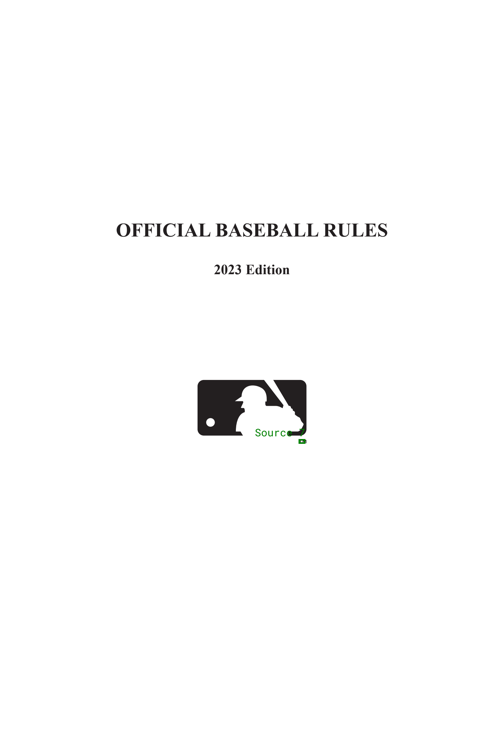

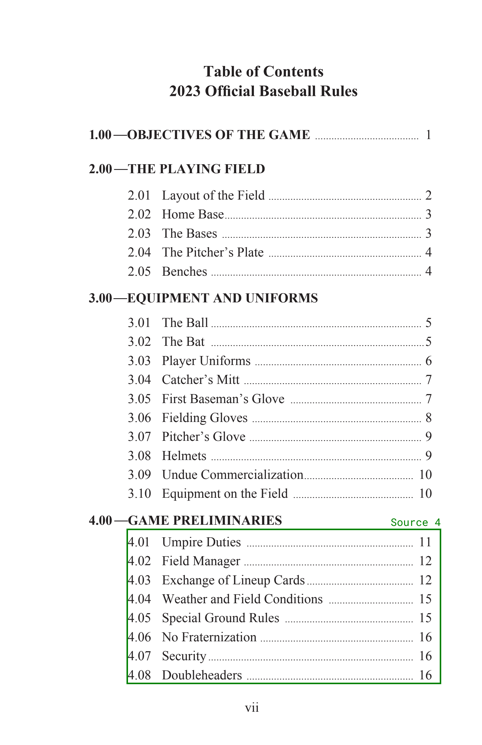

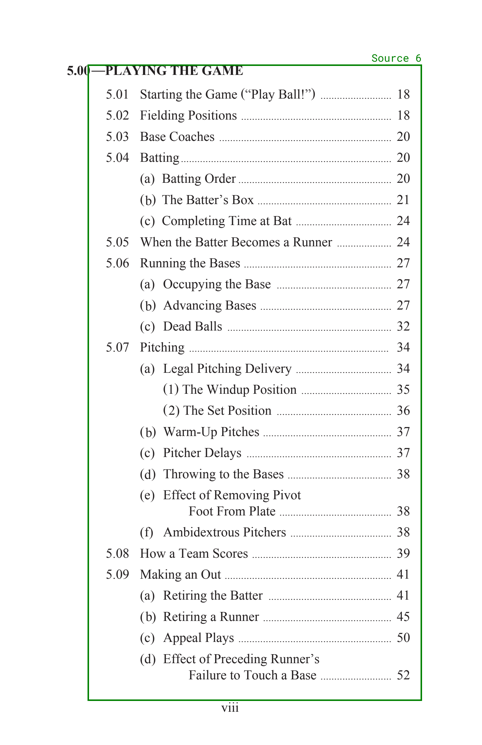

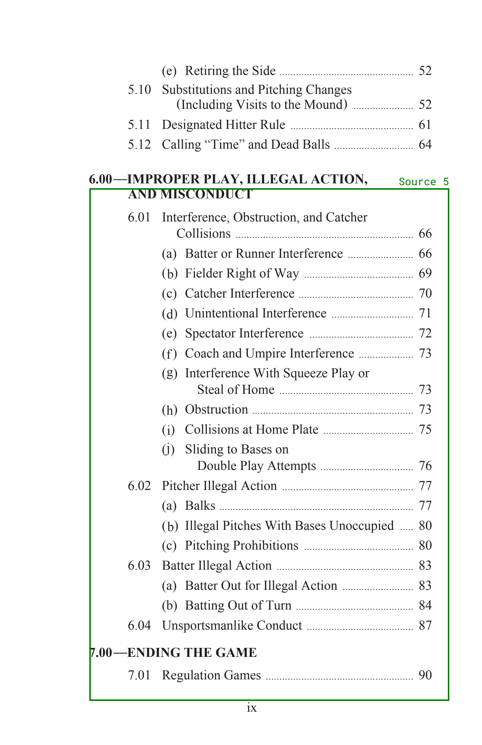

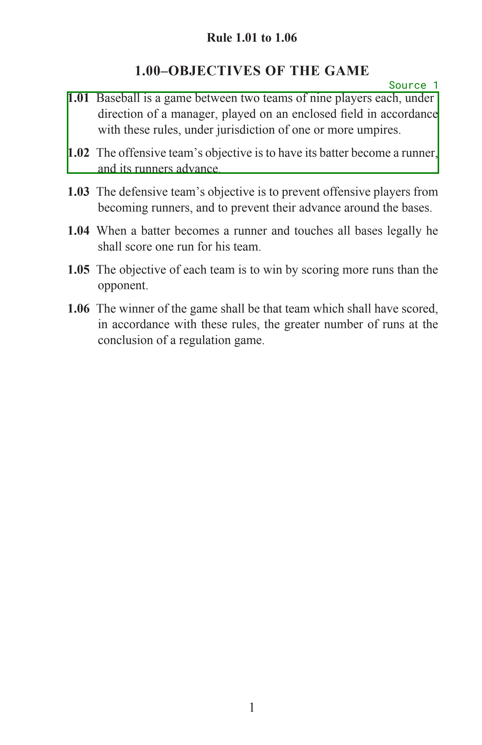

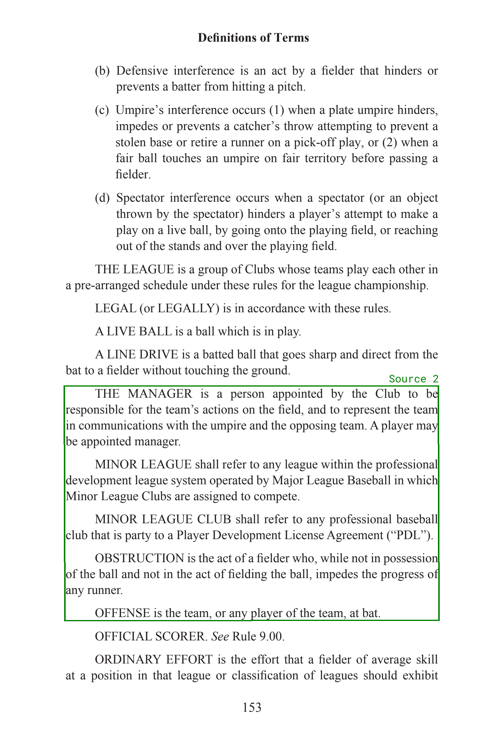

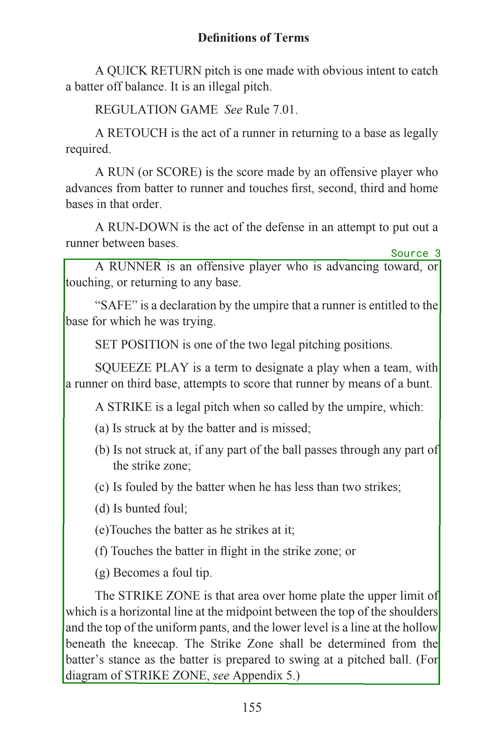

In [168]:
document_bot(question, DISTANCE = 0)

2023-10-26 20:17:51.694849: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 15
2023-10-26 20:17:51.695131: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 228.165us.
2023-10-26 20:17:51.696381: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 7
2023-10-26 20:17:51.696555: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 147.828us.
2023-10-26 20:17:51.697848: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 9
2023-10-26 20:17:51.697999: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 124.969us.
2023-10-26 20:17:51.699273: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 10
2023-10-26 20:17:51.699429: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFact

## Response

### Question

What is the definition of a balk?

### Answer

A balk is an illegal pitch that occurs when the pitcher deceives the base runner.

### Sources

**Note:** The context used text from matching elements within pages. Additionally, surrounding context were gathered using a distance of 0.2 and a direction of 'SEMANTIC'
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=89
	* page: 89, elements relevance to question: 0.80
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=30
	* page: 30, elements relevance to question: 0.78
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=89
	* page: 89, elements relevance to question: 0.76
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=40
	* page: 40, elements relevance to question: 0.67
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=50
	* page: 50, elements relevance to question: 0.67
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=91
	* page: 91, elements relevance to question: 0.66
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=163
	* page: 163, elements relevance to question: 0.66

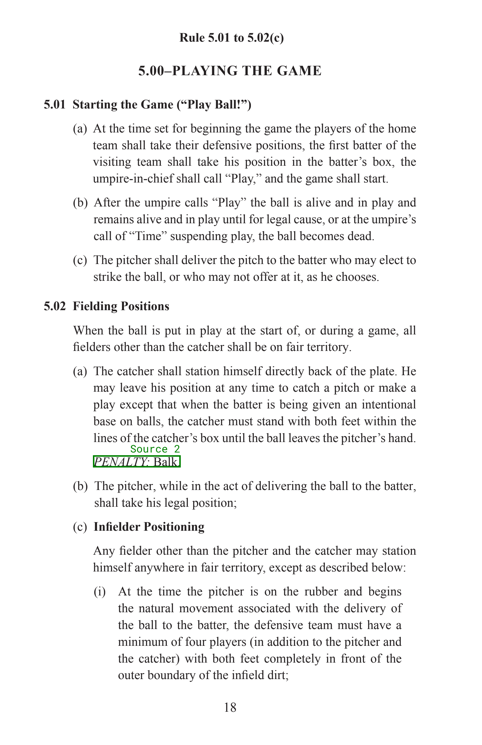

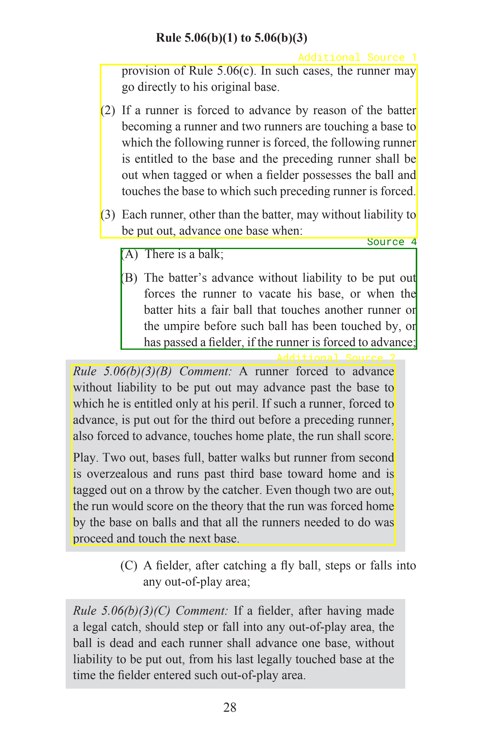

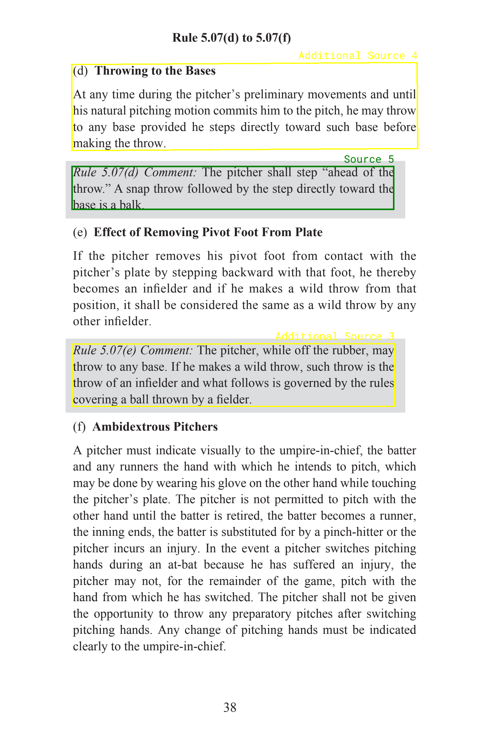

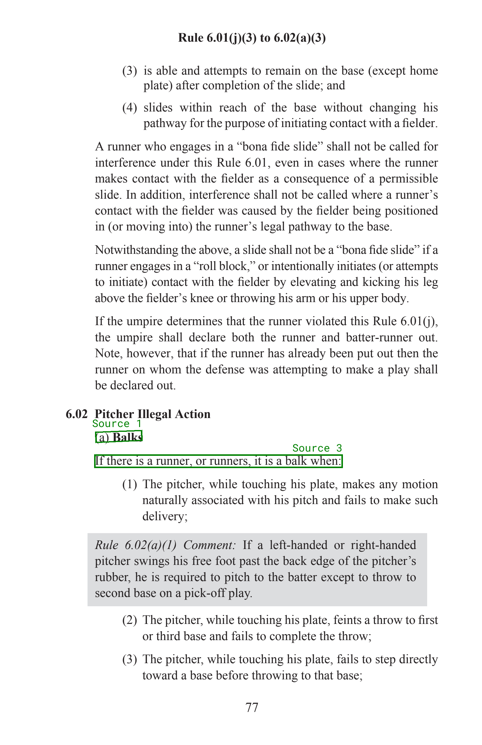

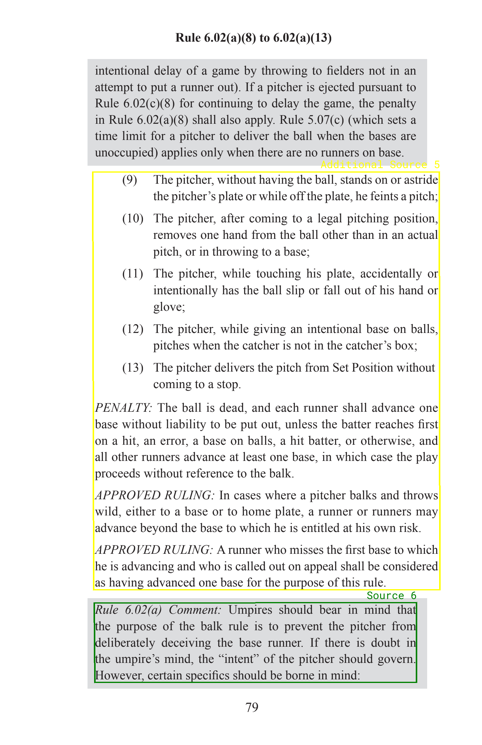

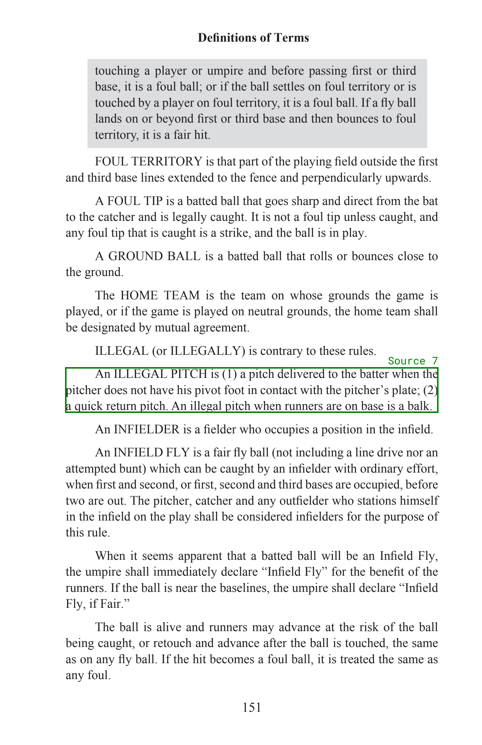

In [169]:
document_bot("What is the definition of a balk?", DISTANCE = 0.2)

2023-10-26 20:17:53.668750: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 6
2023-10-26 20:17:53.668917: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 105.75us.
2023-10-26 20:17:53.670327: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 10
2023-10-26 20:17:53.670488: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 131.956us.
2023-10-26 20:17:53.671632: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 8
2023-10-26 20:17:53.671788: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactory ran in 132.456us.
2023-10-26 20:17:53.673172: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 7
2023-10-26 20:17:53.673288: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:84] PartitionerFactor

## Response

### Question

Is a rule broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball?

### Answer

Yes, a rule is broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball.

The rule is Rule 5.02(c), which states that "from the time the pitcher releases the ball to deliver the first pitch to the first batter of a half inning, the two infielders on each side of second base may not switch sides or move to a position other than their side of the infield for the entirety of that inning."

The purpose of this rule is to prevent the defense from having more than two infielders on either side of second base in an effort to anticipate where the batter will hit the ball prior to delivery of the pitch. If, in the judgment of the umpire, any fielder attempts to circumvent the purposes of this Rule 5.02(c), the umpire shall assess the penalty described below.

### Sources

**Note:** The context used text from matching elements within pages.
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=45
	* page: 45, elements relevance to question: 0.79
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=31
	* page: 31, elements relevance to question: 0.79
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=62
	* page: 62, elements relevance to question: 0.79
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=124
	* page: 124, elements relevance to question: 0.79
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=83
	* page: 83, elements relevance to question: 0.79
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=31
	* page: 31, elements relevance to question: 0.79
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=163
	* page: 163, elements relevance to question: 0.79

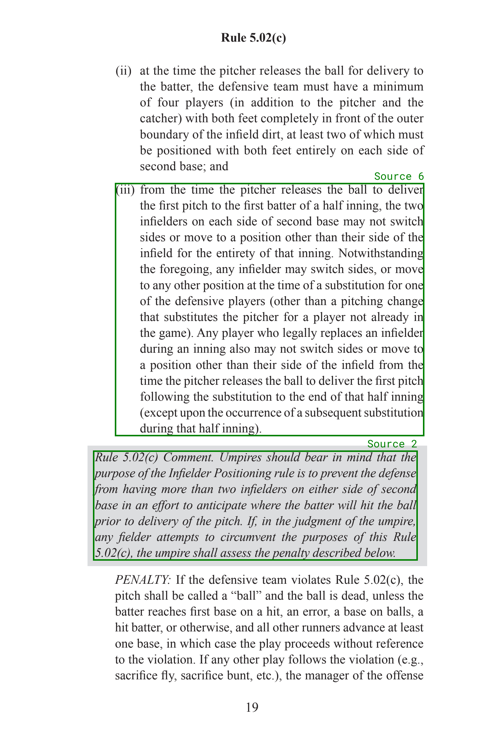

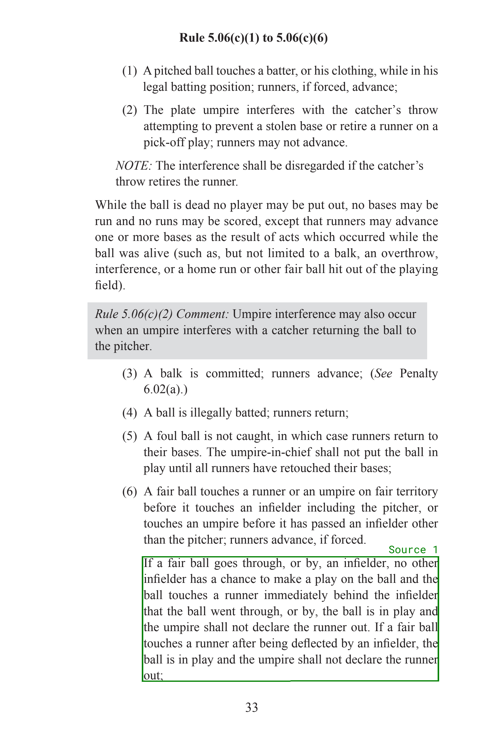

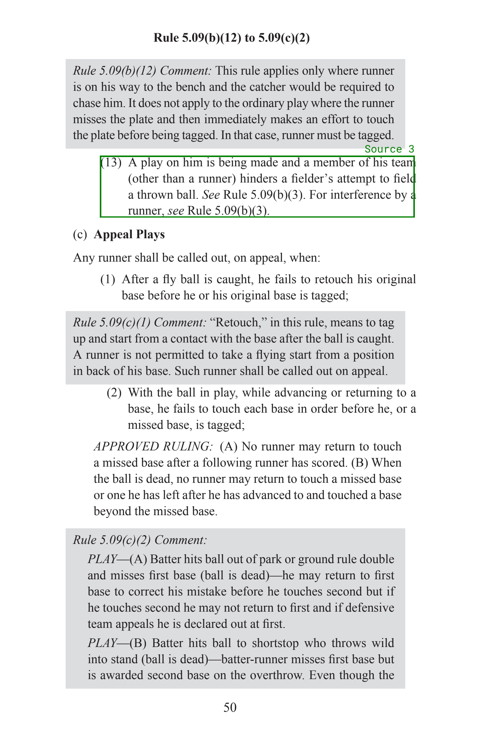

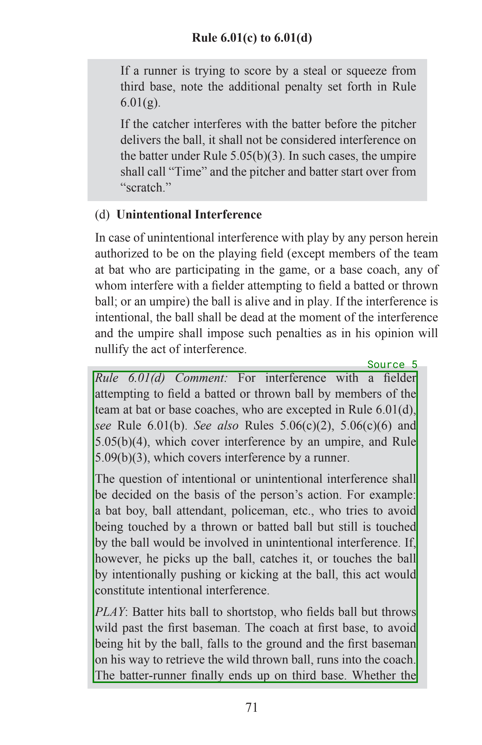

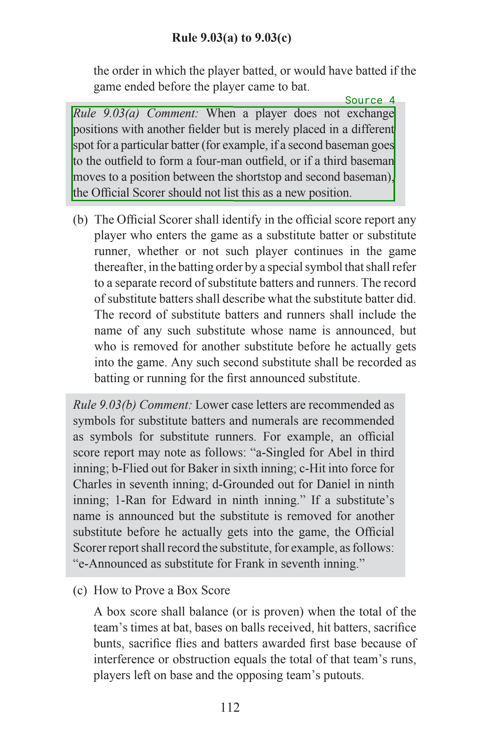

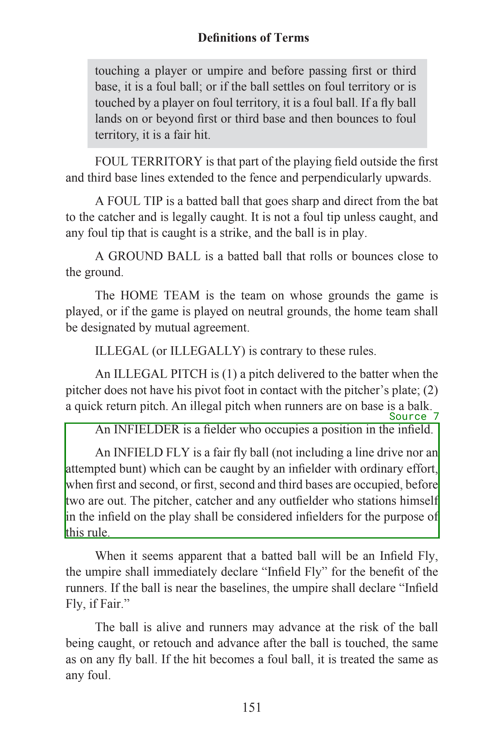

In [170]:
document_bot("Is a rule broken if three infielders are positioned on the same side of the field where the batter is more likely to hit the ball?", DISTANCE = 0.1)

## Response

### Question

A batter hits a ball that goes over the fence, but it is caught by a fan in the stands. Is the ball a home run?

### Answer

Yes, the ball is a home run.

The ball is a home run because it is a fair ball that clears a fence.

### Sources

**Note:** The context used text from matching elements within pages.
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=36
	* page: 36, elements relevance to question: 0.76
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=43
	* page: 43, elements relevance to question: 0.75
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=85
	* page: 85, elements relevance to question: 0.75
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=37
	* page: 37, elements relevance to question: 0.75
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=42
	* page: 42, elements relevance to question: 0.74
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=127
	* page: 127, elements relevance to question: 0.74
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=41
	* page: 41, elements relevance to question: 0.74

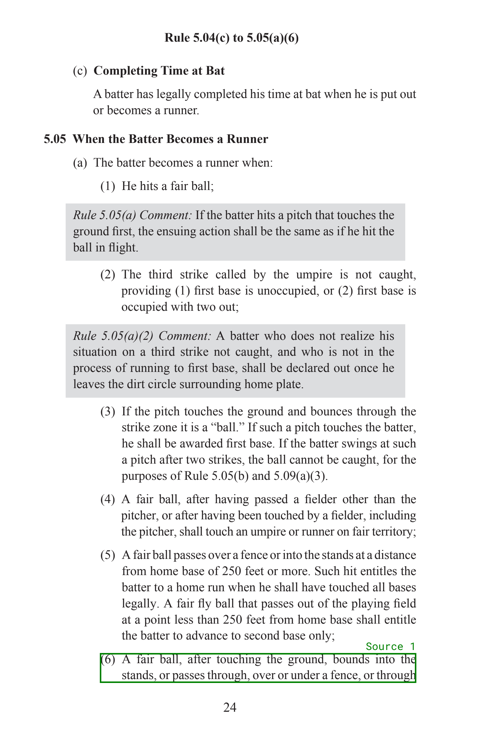

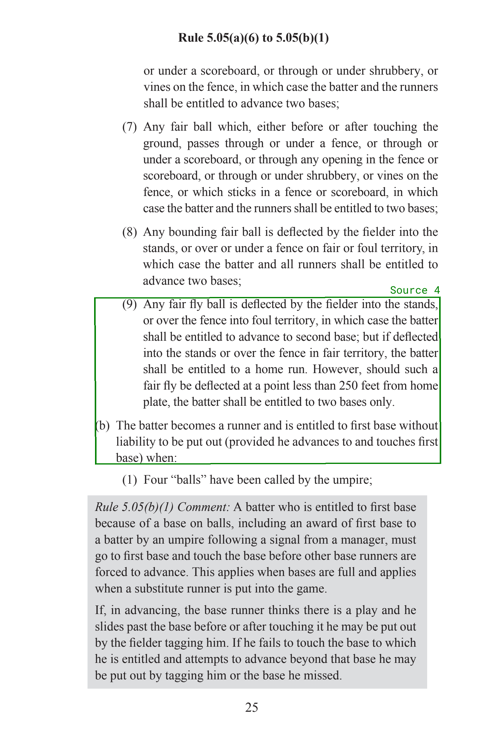

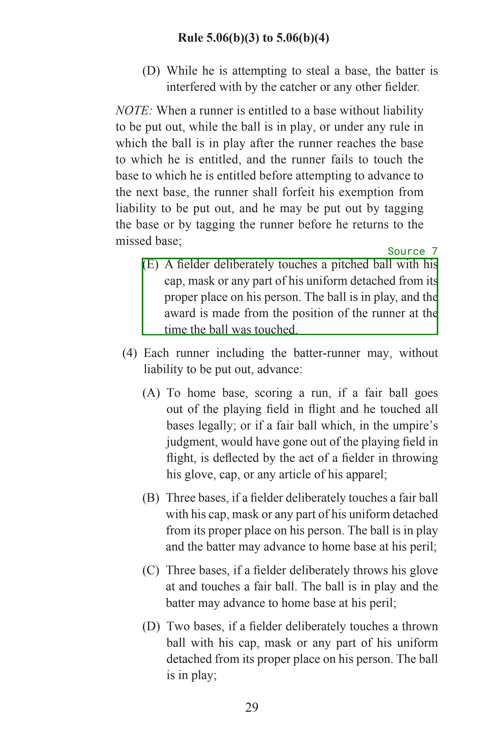

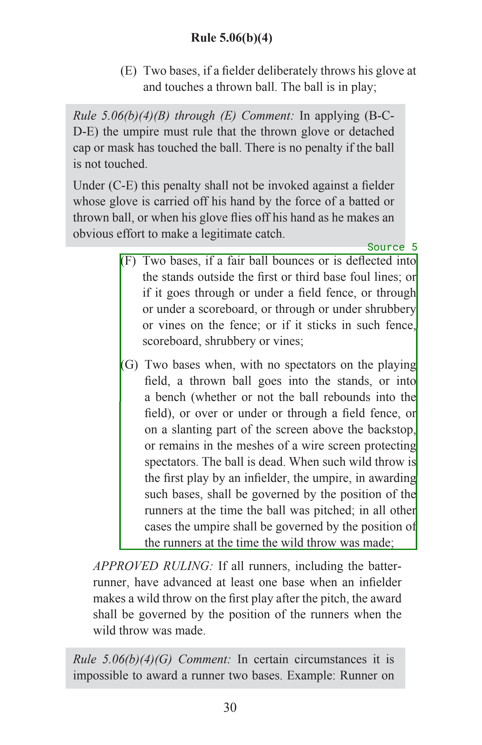

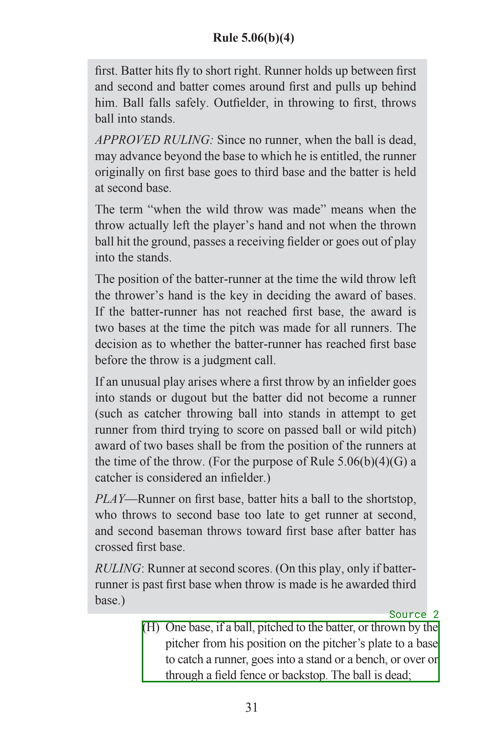

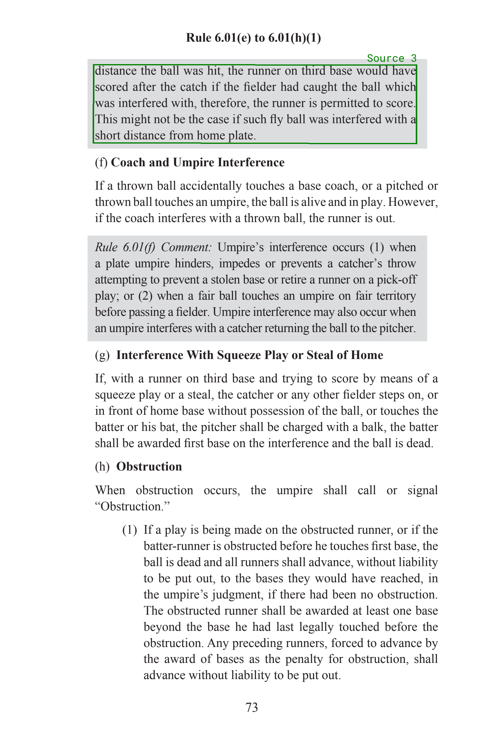

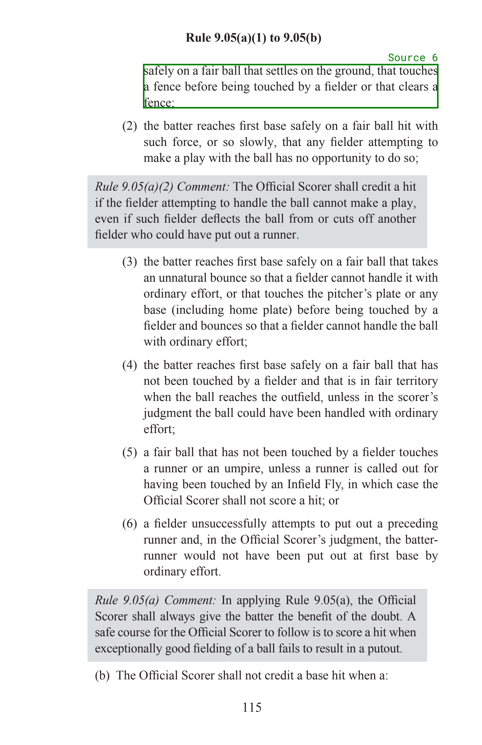

In [171]:
document_bot("A batter hits a ball that goes over the fence, but it is caught by a fan in the stands. Is the ball a home run?", DISTANCE = 0)

## Response

### Question

What is the official size of a base?

### Answer

The official size of a base is 18 inches square, not less than three nor more than five inches thick, and filled with soft material.

### Sources

**Note:** The context used text from matching elements within pages.
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=14
	* page: 14, elements relevance to question: 0.73
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=16
	* page: 16, elements relevance to question: 0.72
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=158
	* page: 158, elements relevance to question: 0.72
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=143
	* page: 143, elements relevance to question: 0.72
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=15
	* page: 15, elements relevance to question: 0.71
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=17
	* page: 17, elements relevance to question: 0.71
1. https://img.mlbstatic.com/mlb-images/image/upload/mlb/wqn5ah4c3qtivwx3jatm.pdf#page=1
	* page: 1, elements relevance to question: 0.71

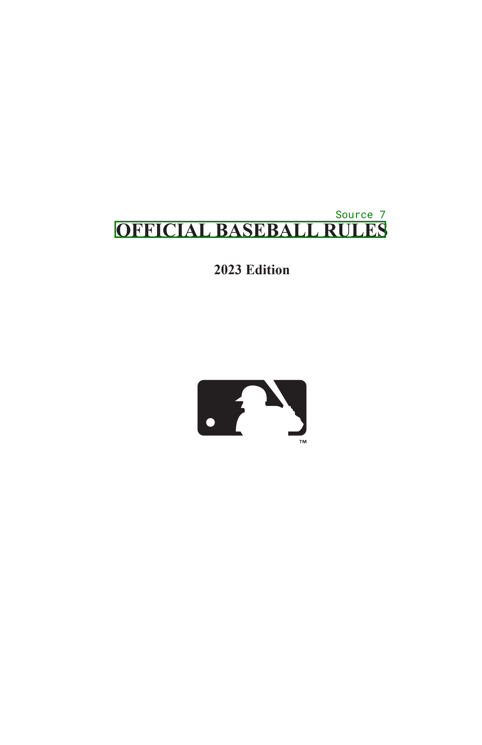

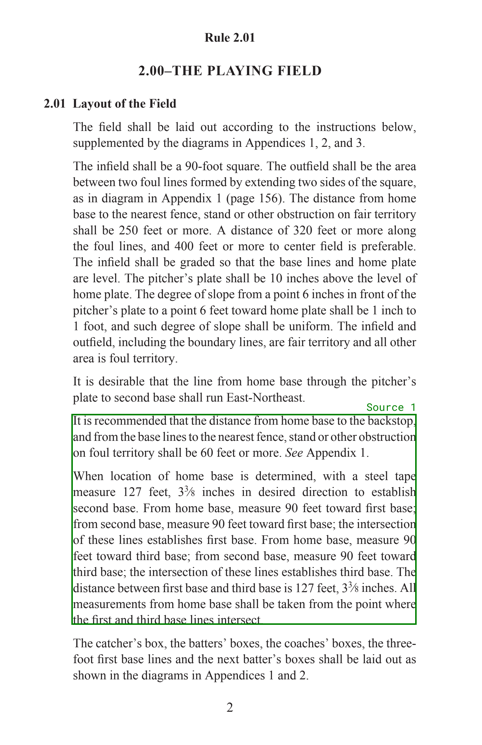

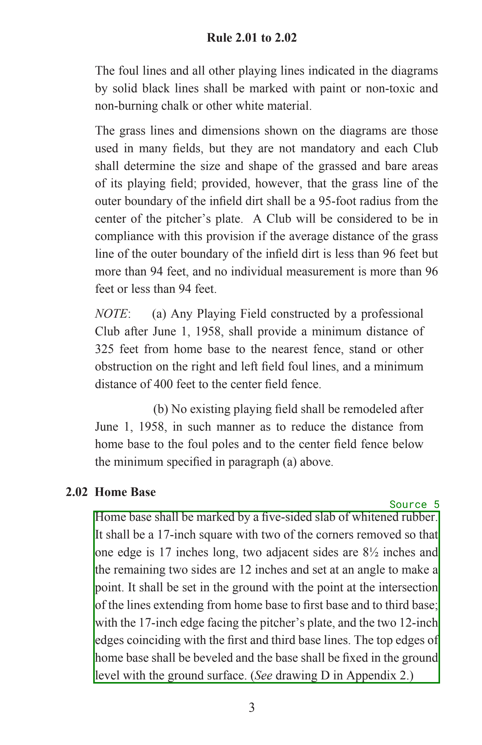

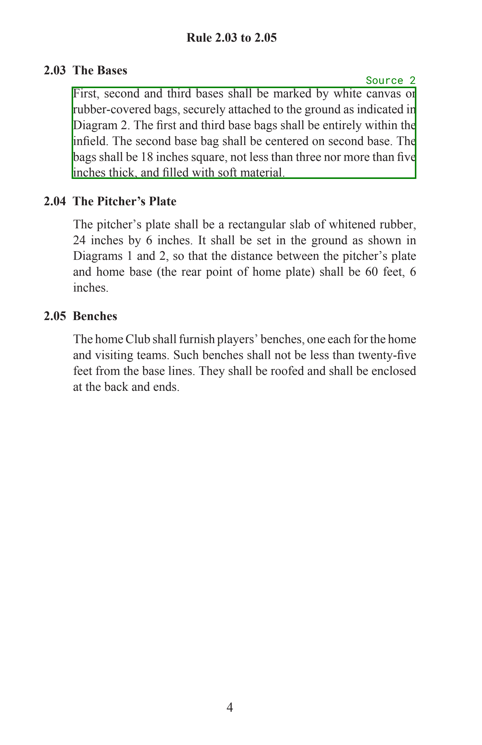

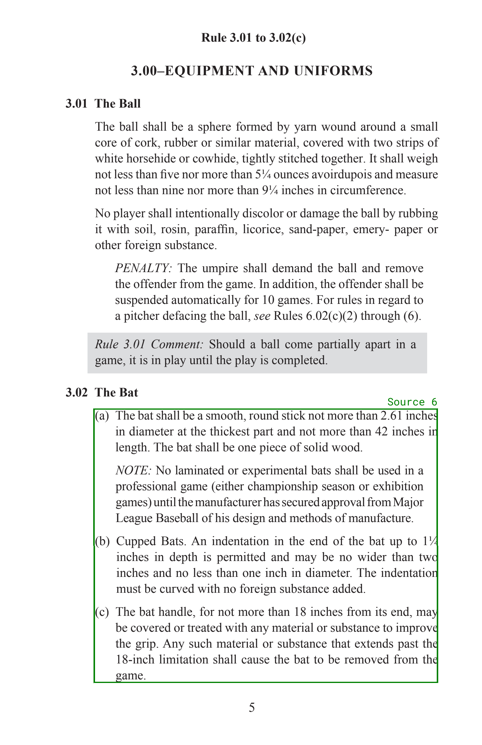

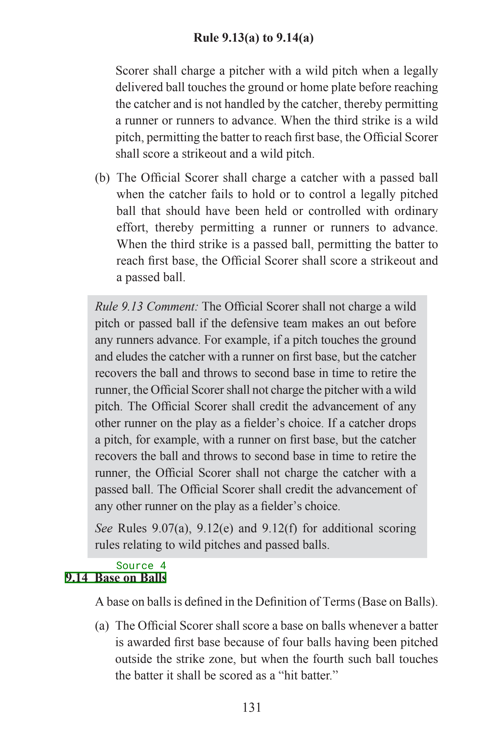

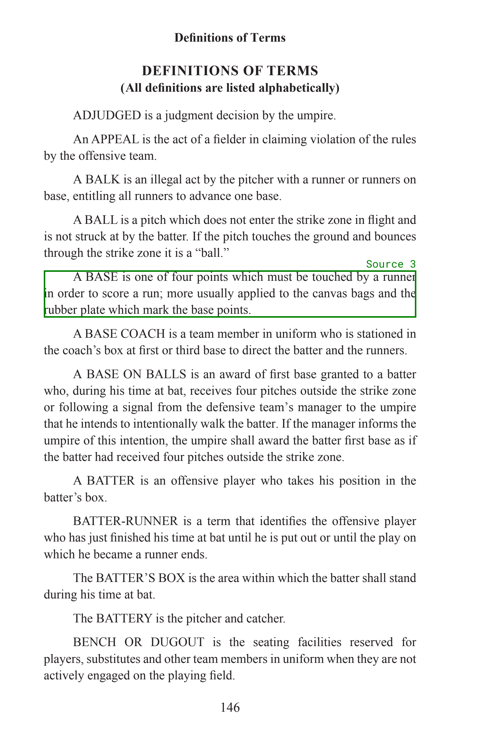

In [172]:
document_bot("What is the official size of a base?")

## Try Asking Off Topic Questions:

In [173]:
document_bot("How do I make a PB&J?")

## Response

### Question

How do I make a PB&J?

### Answer

The question does not appear to be related to my knowledge base.  If this is not correct then try asking again with a few more details 😄

In [174]:
document_bot("3+3=?")

## Response

### Question

3+3=?

### Answer

The question does not appear to be related to my knowledge base.  If this is not correct then try asking again with a few more details 😄